### MCMC pour déterminer les paramètres du modèle hydraulique

📌 Objectif du MCMC :

	•Simuler plusieurs milliers de scénarios réalistes en échantillonnant ces distributions.
	•Calculer à chaque simulation la hauteur d’eau  H  et la surverse  S .
	•Extraire des statistiques utiles (médiane, moyenne, intervalle de confiance) 

| Paramètre                        | Loi de probabilité mentionnée                                      |
|----------------------------------|------------------------------------------------------------------|
| Débit Q                   | Loi triangulaire (Q_min, Q_mode, Q_max)     |
| Coefficient de Strickler K_s | Loi triangulaire (K_s,min, K_s,mode, K_s,max) |
| Hauteur de la digue h_d    | Constante (pas mentionnée comme incertaine)                     |
| Cote du fond en amont Z_m et en aval Z_v | Constante (non explicitement mentionnée comme incertaine) |

### 📂 Importation des données & librairies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
L = 5000 
B = 300   
hd = 5.50 # Hauteur de la digue (m) isu de l'analyse des crues
Zb = 55.5 
N = 5000 #arbitraire

Q_samples = np.zeros(N)
Ks_samples = np.zeros(N)
Zv_samples = np.zeros(N)
Zm_samples = np.zeros(N)
H_samples = np.zeros(N)
S_samples = np.zeros(N)

# Conditions initiales posées arbitrairement
Q_samples[0] = 1013  
Ks_samples[0] = 30   
Zv_samples[0] = 50   
Zm_samples[0] = 55 

Définitions de mes lois 

In [4]:
def gumbel_pdf(x, mode=1013, beta=558):
    return (1/beta) * np.exp(-(x - mode) / beta) * np.exp(-np.exp(-(x - mode) / beta))

def normal_pdf(x, mu=30, sigma=7.5):
    return (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def triangular_pdf(x, lower, upper, mode):
    if lower <= x <= mode:
        return 2 * (x - lower) / ((upper - lower) * (mode - lower))
    elif mode < x <= upper:
        return 2 * (upper - x) / ((upper - lower) * (upper - mode))
    else:
        return 0

In [ ]:
#metropolis-hastings
for i in range(1, N):

    #éviter les valeurs négatives
    Q_prop = max(0.1, np.random.normal(Q_samples[i-1], 50))  
    Ks_prop = max(0.1, np.random.normal(Ks_samples[i-1], 2))
    Zv_prop = np.random.normal(Zv_samples[i-1], 0.5)
    Zm_prop = max(Zv_prop + 0.1, np.random.normal(Zm_samples[i-1], 0.5))  # Assure Zm > Zv

    alpha_Q = min(1, gumbel_pdf(Q_prop) / gumbel_pdf(Q_samples[i-1]))
    alpha_Ks = min(1, normal_pdf(Ks_prop) / normal_pdf(Ks_samples[i-1]))
    alpha_Zv = min(1, triangular_pdf(Zv_prop, 49, 51, 50) / triangular_pdf(Zv_samples[i-1], 49, 51, 50))
    alpha_Zm = min(1, triangular_pdf(Zm_prop, 54, 56, 55) / triangular_pdf(Zm_samples[i-1], 54, 56, 55))

    Q_samples[i] = Q_prop if np.random.rand() < alpha_Q else Q_samples[i-1]
    Ks_samples[i] = Ks_prop if np.random.rand() < alpha_Ks else Ks_samples[i-1]
    Zv_samples[i] = Zv_prop if np.random.rand() < alpha_Zv else Zv_samples[i-1]
    Zm_samples[i] = Zm_prop if np.random.rand() < alpha_Zm else Zm_samples[i-1]

    #H
    delta_Z = max(0.001, Zm_samples[i] - Zv_samples[i])  # Empêche une valeur négative
    H_samples[i] = (Q_samples[i] / (Ks_samples[i] * np.sqrt(delta_Z / L) * B)) ** (3/5)

    #S
    S_samples[i] = Zv_samples[i] + H_samples[i] - hd - Zb

$$H = \left( \frac{Q}{K_s \sqrt{\frac{Z_m - Z_v}{L} B}} \right)^{\frac{3}{5}}$$

$$S = Z_v + H - h_d - Z_b$$

# Simulation MCMC

À chaque itération, des valeurs de $Q$, $K_s$, $Z_v$ et $Z_m$ sont tirées en respectant leurs distributions de probabilité.  
Ces valeurs sont ensuite utilisées pour calculer $H$ et $S$.

- À chaque étape, de nouvelles valeurs aléatoires de $Q$, $K_s$, $Z_v$ et $Z_m$ sont proposées.  
- Ces valeurs sont acceptées ou rejetées en fonction de leur probabilité d’occurrence.  
- Ce processus est répété un grand nombre de fois afin d'obtenir une distribution complète de $H$ et $S$.

Statistiques descriptives

In [6]:
H_stats = np.median(H_samples), np.mean(H_samples), np.percentile(H_samples, [2.5, 97.5])
S_stats = np.median(S_samples), np.mean(S_samples), np.percentile(S_samples, [2.5, 97.5])

print(f"\n🔹 H : Moy={H_stats[1]:.2f} m, Med={H_stats[0]:.2f} m, IC95%=[{H_stats[2][0]:.2f}, {H_stats[2][1]:.2f}] m")
print(f"🔹 S : Moy={S_stats[1]:.2f} m, Med={S_stats[0]:.2f} m, IC95%=[{S_stats[2][0]:.2f}, {S_stats[2][1]:.2f}] m")


🔹 H : Moy=2.85 m, Med=2.64 m, IC95%=[1.47, 5.25] m
🔹 S : Moy=-8.15 m, Med=-8.32 m, IC95%=[-9.89, -5.68] m


In [7]:
H_mean, H_std = np.mean(H_samples), np.std(H_samples)
S_mean, S_std = np.mean(S_samples), np.std(S_samples)
H_lower, H_upper = np.percentile(H_samples, [2.5, 97.5])
S_lower, S_upper = np.percentile(S_samples, [2.5, 97.5])

H_summary = {
    "Hauteur d'eau moyenne (H)": H_mean,
    "Écart-type (H)": H_std,
    "IC 95% inf. (H)": H_lower,
    "IC 95% sup. (H)": H_upper
}

S_summary = {
    "Surverse moyenne (S)": S_mean,
    "Écart-type (S)": S_std,
    "IC 95% inf. (S)": S_lower,
    "IC 95% sup. (S)": S_upper
}

df_summary = pd.DataFrame([H_summary, S_summary], index=["H", "S"])


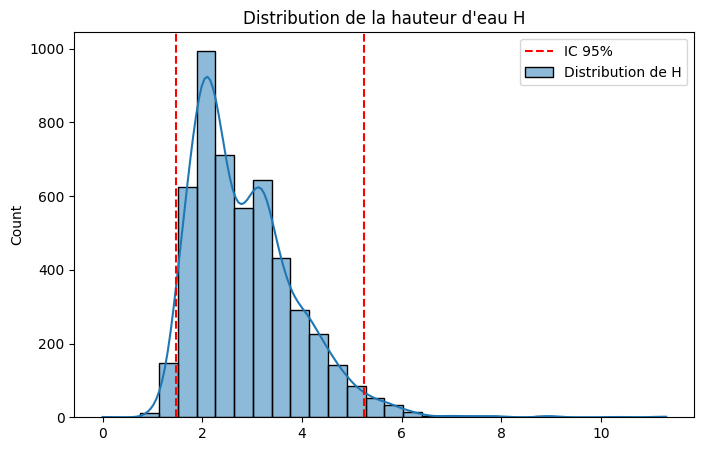

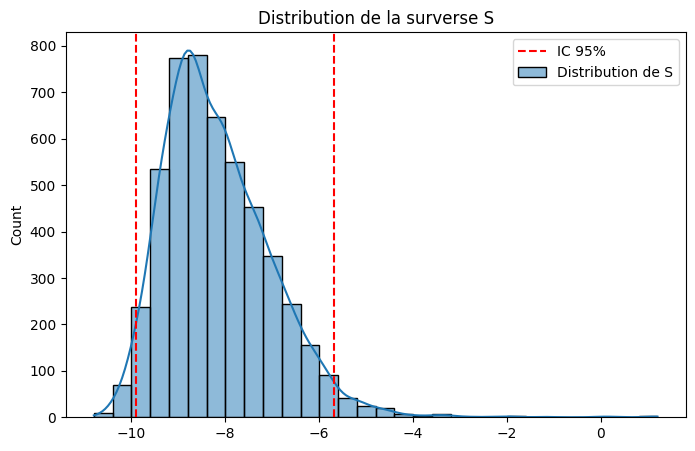

In [8]:

# Affichage des distributions
plt.figure(figsize=(8,5))
sns.histplot(H_samples, kde=True, bins=30, label="Distribution de H")
plt.axvline(H_lower, color="red", linestyle="dashed", label="IC 95%")
plt.axvline(H_upper, color="red", linestyle="dashed")
plt.legend()
plt.title("Distribution de la hauteur d'eau H")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(S_samples, kde=True, bins=30, label="Distribution de S")
plt.axvline(S_lower, color="red", linestyle="dashed", label="IC 95%")
plt.axvline(S_upper, color="red", linestyle="dashed")
plt.legend()
plt.title("Distribution de la surverse S")
plt.show()

In [9]:
H_stats = np.median(H_samples), np.mean(H_samples), np.percentile(H_samples, [2.5, 97.5])
S_stats = np.median(S_samples), np.mean(S_samples), np.percentile(S_samples, [2.5, 97.5])

print(f"\n🔹 H : Moy={H_stats[1]:.2f} m, Med={H_stats[0]:.2f} m, IC95%=[{H_stats[2][0]:.2f}, {H_stats[2][1]:.2f}] m")
print(f"🔹 S : Moy={S_stats[1]:.2f} m, Med={S_stats[0]:.2f} m, IC95%=[{S_stats[2][0]:.2f}, {S_stats[2][1]:.2f}] m")


🔹 H : Moy=2.85 m, Med=2.64 m, IC95%=[1.47, 5.25] m
🔹 S : Moy=-8.15 m, Med=-8.32 m, IC95%=[-9.89, -5.68] m


Trouvons la hauteur optimal


🔹 Résultats de l’optimisation de la digue 🔹
    Hauteur digue (m)  P(S > 0)
0            0.000000    0.0198
1            0.526316    0.0102
2            1.052632    0.0052
3            1.578947    0.0036
4            2.105263    0.0024
5            2.631579    0.0016
6            3.157895    0.0014
7            3.684211    0.0008
8            4.210526    0.0008
9            4.736842    0.0006
10           5.263158    0.0006
11           5.789474    0.0004
12           6.315789    0.0004
13           6.842105    0.0000
14           7.368421    0.0000
15           7.894737    0.0000
16           8.421053    0.0000
17           8.947368    0.0000
18           9.473684    0.0000
19          10.000000    0.0000

✅ Hauteur optimale de la digue : 1.05 m (où P(S > 0) < 1%)


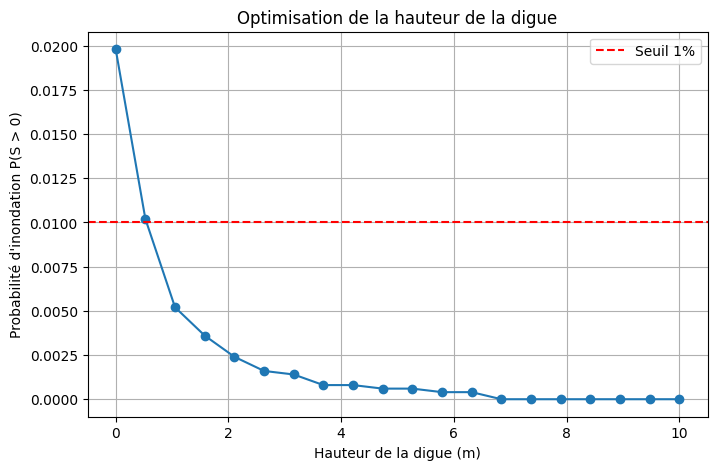

In [ ]:
hd_values = np.linspace(0, 10, 20)  

# probabilité d'inondation pour chaque hauteur de digue
P_inondation_hd = []
for hd_test in hd_values:
    S_samples = Zv_samples + H_samples - hd_test - Zb
    P_inondation = np.mean(S_samples > 0)
    P_inondation_hd.append(P_inondation)

# Trouver la plus petite hauteur où P(S > 0) < 1%
optimal_hd_index = next((i for i, p in enumerate(P_inondation_hd) if p < 0.01), None)
optimal_hd = hd_values[optimal_hd_index] if optimal_hd_index is not None else None

df_hd_optimal = pd.DataFrame({
    "Hauteur digue (m)": hd_values,
    "P(S > 0)": P_inondation_hd
})

print("\n🔹 Résultats de l’optimisation de la digue 🔹")
print(df_hd_optimal)
if optimal_hd:
    print(f"\n✅ Hauteur optimale de la digue : {optimal_hd:.2f} m (où P(S > 0) < 1%)")
else:
    print("✅ Toutes les hauteurs testées sont suffisantes (P(S > 0) = 0)")

plt.figure(figsize=(8,5))
plt.plot(hd_values, P_inondation_hd, marker='o', linestyle='-')
plt.axhline(y=0.01, color='r', linestyle='--', label="Seuil 1%")
plt.xlabel("Hauteur de la digue (m)")
plt.ylabel("Probabilité d'inondation P(S > 0)")
plt.title("Optimisation de la hauteur de la digue")
plt.legend()
plt.grid()
plt.show()